Работа № 4 Щелыкалов Виткор
1. Реализовать метод локальной аппроксимации, как он описан у проф. А.Ю. Лоскутова и продемонстрировать его применение к имеющимся рядам.
2. Сделать вывод о качестве прогноза и применимости к разного рода процессам.
3. Альтернативный вариант: тоже для метода максимального подобия им. И. А. Чучуевой

In [13]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

### Временной ряд с явными периодами

<Axes: title={'center': 'Daily min temperature'}, xlabel='date'>

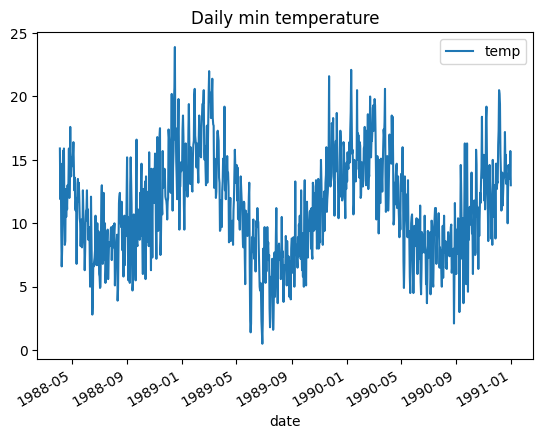

In [11]:
min_temp = pd.read_csv('data/daily-min-temperatures.csv')
min_temp = min_temp[-1000:]
min_temp.date = pd.to_datetime(min_temp.date)
min_temp = min_temp.set_index('date')
min_temp.plot(title="Daily min temperature")

### Хаотичный ряд

<Axes: title={'center': 'BTCUSDT 1m close price'}, xlabel='time'>

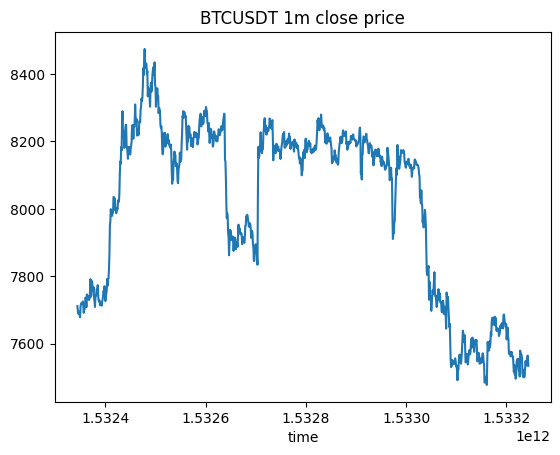

In [12]:
close_price = pd.read_csv('data/cryptoPrices15_wNB.csv')
close_price = close_price[['time','BTCUSDT']]
close_price = close_price[-1000:]
close_price= close_price.set_index('time')
close_price['BTCUSDT'].plot(title='BTCUSDT 1m close price')

### Метод локальной аппроксимации

In [380]:
def predict(ts: list, neighbors_count: int):
  # def get_neighbors(curr_ts: list, n: list):
  #   x = curr_ts[-1]
  #   neighbors = sorted(curr_ts, key=lambda y: abs(y-x))[1:n+1]
  #   after_neighbors = []
  #   for neighbor in neighbors:
  #     after_neighbors.append(curr_ts[curr_ts.index(neighbor)+1])
  #   return after_neighbors

  def get_neighbors(curr_ts: list, n: list):
    x = curr_ts[-1]
    curr_ts = curr_ts[:-1]
    areas = np.array_split(curr_ts, n)
    after_neighbors = []
    for area in areas:
      neighbor = sorted(area, key=lambda y: abs(y-x))[0]
      after_neighbors.append(curr_ts[curr_ts.index(neighbor)])
    return after_neighbors

  def calc_polynomial(neighbors: list, a: list):
    x_next = 0
    for i in range(0, len(neighbors)):
      x_next += neighbors[i] * a[i]
    return x_next

  def error(a):
    for j in range(len(ts)-20, len(ts)):
      error = 0
      curr_neighbors = get_neighbors(ts[:j-1], neighbors_count)
      x_next = calc_polynomial(curr_neighbors, a)
      error += (ts[j]-x_next) * (ts[j]-x_next)
    return error

  a = least_squares(error, np.array([0 for i in range(neighbors_count)])).x
  curr_neighbors = get_neighbors(ts, neighbors_count)
  x_next = calc_polynomial(curr_neighbors, a)
  return x_next


In [ ]:
neighbors_count = 10
ts_close_price = close_price['BTCUSDT'].tolist()[:-150]

for i in range(150):
  x_next = predict(ts_close_price, neighbors_count)
# x_next
  ts_close_price.append(x_next)

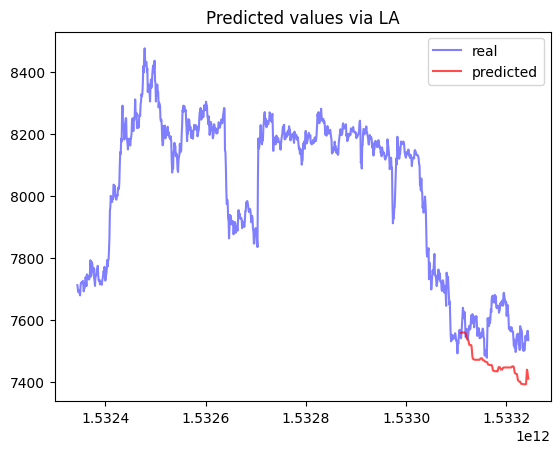

In [382]:
plt.plot(close_price.index, close_price['BTCUSDT'], color='b', label='real', alpha=0.5)
plt.plot(close_price.index.tolist()[-150:], ts_close_price[-150:], color='r', label='predicted', alpha=0.7)
plt.title('Predicted values via LA')
plt.legend()
plt.show()

In [ ]:
neighbors_count = 10
ts_temp = min_temp['temp'].tolist()[:-150]

for i in range(150):
  x_next = predict(ts_temp, neighbors_count)
  ts_temp.append(x_next)

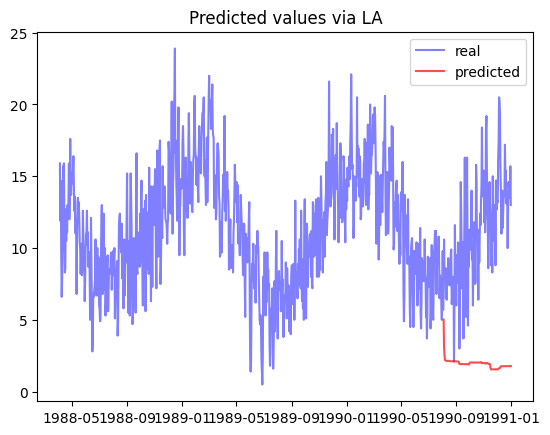

In [384]:
plt.plot(min_temp.index, min_temp['temp'], color='b', label='real', alpha=0.5)
plt.plot(min_temp.index.tolist()[-150:], ts_temp[-150:], color='r', label='predicted', alpha=0.7)
plt.title('Predicted values via LA')
plt.legend()
plt.show()

Кажется, что для циклического ряда метод локальной аппроксимации подходит меньше, чем для хаотичного ряда. Однако он имеет ряд недостатков: сложность подбора количества необходимых соседей и аппроксимирующей модели(как правило, используется эмпирический метод), необходимость мириться с компромиссом между увеличением порядка модели и количеством соседей.

Подробнее: https://www.semanticscholar.org/reader/2201799bcee5304c985f01496d9a6cbaaae1bbdf